In [5]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim

### Preparing Configurations

In [6]:
""" 
Information about architecture config:
Tuple is structured by and signifies a convolutional block (filters, kernel_size, stride) 
Every convolutional layer is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats. 
"S" is for a scale prediction block and computing the yolo loss
"U" is for upsampling the feature map
"""
config = [
    (32, 3, 1),  ## OutChannels Kernel Size, Stride
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["B", 8], 
    # second route from the end of the previous block
    (1024, 3, 2),
    ["B", 4],
    # until here is YOLO-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

#### Defining the Architecture

In [7]:
### CNN block
class CNNBlock(nn.Module):
    def __init__(self,in_channels:int,out_channels:int, is_batch_norm: bool, **kwargs) -> None:
        super().__init__()
        ## Initializing the Convolution Layer
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,bias = not is_batch_norm,**kwargs)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.is_batch = is_batch_norm

    def forward(self,x ):
        ## Recieves x  as [Batch, channels, X, Y]
        x = self.conv(x) if not self.is_batch else self.leaky_relu(self.batch_norm(self.conv(x)))
        return x
        

In [8]:
### Residual Block
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,num_repeats,use_residual) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.num_repeats = num_repeats
        self.use_residual = use_residual
        
        ## We just shrink the channels (Feature Size Remain the same)
        for i in range(self.num_repeats):
            self.layers +=[
                nn.Sequential(
                CNNBlock(in_channels=in_channels,out_channels=in_channels//2,is_batch_norm=True,kernel_size = 1),
                CNNBlock(in_channels=in_channels//2,out_channels=in_channels,is_batch_norm=True,kernel_size = 3, padding = 1)
                )
            ]
            
    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x) + x if self.use_residual else layer(x)
        
        return x
        

In [9]:
### Scale Prediction
class ScalePrediction(nn.Module):
    def __init__(self,in_channels,num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.pred = nn.Sequential(
            CNNBlock(in_channels=in_channels,out_channels=in_channels*2, is_batch_norm=True, kernel_size = 3, padding = 1),
            CNNBlock(in_channels=in_channels*2,out_channels=(self.num_classes+5)*3, is_batch_norm=False, kernel_size = 1)
        )
        
    def forward(self, x):
        
        x = self.pred(x)
        x = x.view(x.shape[0], 3 , (self.num_classes + 5),x.shape[2], x.shape[3])
        ## Output Should be (Batch, 3 (for anchors), 13, 13, Num Classes + 5)
        return x.permute(0,1,3,4,2)


In [10]:
temp = ScalePrediction(3,90)
batch = torch.rand(5 , 3, 13, 13)
out = temp(batch)

In [11]:
out.size()

torch.Size([5, 3, 13, 13, 95])

In [16]:
### YOLOv3 Class
class YOLOv3(nn.Module):
    def __init__(self,in_channels,num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels 
        self.layers_model = self._create_conv()
        
        
    def forward(self, x ):
        
        outputs_scale = []
        routing = []
        
        for layer in self.layers_model:
            
            
            if isinstance(layer,ScalePrediction):
                outputs_scale.append(layer(x))
                continue
            x = layer(x)
            if isinstance(layer,ResidualBlock) and layer.num_repeats == 8:
                routing.append(x)
            if isinstance(layer,nn.Upsample):
                x = torch.cat([x,routing[-1]], dim = 1)
                routing.pop()
                
        return outputs_scale
        
    def _create_conv(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        for category in config:
            if isinstance(category,tuple):
                out_channels, kernel_size, stride = category
                layers +=[
                    CNNBlock(in_channels=in_channels,out_channels=out_channels,is_batch_norm=True, \
                        kernel_size = kernel_size,stride = stride,
                        padding  = 1 if kernel_size == 3 else 0)
                ]
                in_channels = out_channels
                
            if isinstance(category,list):
                _,repeats = category
                layers.append(ResidualBlock(in_channels=in_channels,num_repeats=repeats,use_residual=True))
            
            if isinstance(category,str):
                if category == "S":
                    layers +=[
                        ResidualBlock(in_channels=in_channels,num_repeats=1, use_residual=False),
                        CNNBlock(in_channels=in_channels,out_channels=in_channels//2, kernel_size = 1,is_batch_norm=True),
                        ScalePrediction(in_channels=in_channels//2,num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2
                elif category == "U":
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3
                    
        return layers
        

In [17]:
yolo = YOLOv3(3,20)
print(yolo)

YOLOv3(
  (layers_model): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): CNNBlock(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky_relu): LeakyReLU(negative_slope=0.1)
          )
          (1): CNNBlock(
            (conv): Conv2d(32, 64, kernel_size

In [18]:
# Testing Code
num_classes = 20
image_size = 416
model = YOLOv3(in_channels=3, num_classes=num_classes)

rand_sample = torch.rand((2, 3, image_size, image_size))
out = model(rand_sample)

assert out[0].shape == (2, 3, image_size // 32, image_size // 32, num_classes + 5)
assert out[1].shape == (2, 3, image_size // 16, image_size // 16, num_classes + 5)
assert out[2].shape == (2, 3, image_size // 8, image_size // 8, num_classes + 5)

print("success")

success


### Data Preparation

In [2]:
import os 
data_path = "../data/export"
labels = os.path.join(data_path,"_darknet.labels")

In [8]:
label_txt = open(labels).read()

In [10]:
label_state = label_txt.split("\n")

In [12]:
lb_idx ={
        lb:idx
    for idx,lb in enumerate(label_state)
}
idx_lb = {
      idx:lb
    for idx,lb in enumerate(label_state)
}  

In [29]:
lb_idx

{'biker': 0,
 'car': 1,
 'pedestrian': 2,
 'trafficLight': 3,
 'trafficLight-Green': 4,
 'trafficLight-GreenLeft': 5,
 'trafficLight-Red': 6,
 'trafficLight-RedLeft': 7,
 'trafficLight-Yellow': 8,
 'trafficLight-YellowLeft': 9,
 'truck': 10}

In [30]:
idx_lb

{0: 'biker',
 1: 'car',
 2: 'pedestrian',
 3: 'trafficLight',
 4: 'trafficLight-Green',
 5: 'trafficLight-GreenLeft',
 6: 'trafficLight-Red',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-Yellow',
 9: 'trafficLight-YellowLeft',
 10: 'truck'}

In [14]:
all_files = os.listdir(data_path)

In [23]:
all_images = [ x  for x in filter(lambda x: x.split(".")[-1] == "jpg",all_files)]
all_txt = [ x  for x in filter(lambda x: x.split(".")[-1] == "txt",all_files)]

In [26]:
import pandas as pd
df = pd.DataFrame({"images":all_images,"metadata":all_txt})

In [27]:
df.head()

,images,metadata
0,1478019952686311006_jpg.rf.54e2d12dbabc46be3c7...,1478019952686311006_jpg.rf.54e2d12dbabc46be3c7...
1,1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF...,1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF...
2,1478019953180167674_jpg.rf.8a816c9d7e9b423a63e...,1478019953180167674_jpg.rf.8a816c9d7e9b423a63e...
3,1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLT...,1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLT...
4,1478019953689774621_jpg.rf.2e4b7ae29c3379da128...,1478019953689774621_jpg.rf.2e4b7ae29c3379da128...


In [28]:
df.to_csv(os.path.join(data_path,"data.csv"))

In [ ]:
df

In [31]:
import torch

In [32]:
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]


In [33]:
x  = torch.tensor(ANCHORS[0] + ANCHORS[1] +ANCHORS[2])

In [34]:
x.shape

torch.Size([9, 2])

In [35]:
!pip install albumentations

In [40]:
import cv2
import numpy as np

In [41]:
df.head()

,images,metadata
0,1478019952686311006_jpg.rf.54e2d12dbabc46be3c7...,1478019952686311006_jpg.rf.54e2d12dbabc46be3c7...
1,1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF...,1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF...
2,1478019953180167674_jpg.rf.8a816c9d7e9b423a63e...,1478019953180167674_jpg.rf.8a816c9d7e9b423a63e...
3,1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLT...,1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLT...
4,1478019953689774621_jpg.rf.2e4b7ae29c3379da128...,1478019953689774621_jpg.rf.2e4b7ae29c3379da128...


In [42]:
image = df.iloc[0]['images']
metadata = df.iloc[0]['metadata']

In [44]:
load_txt= np.loadtxt(os.path.join(data_path,metadata),delimiter = " ", ndmin = 2)

In [45]:
load_txt

array([[10.        ,  0.43359375,  0.48828125,  0.01660156,  0.02832031],
       [ 1.        ,  0.45898438,  0.49414062,  0.02441406,  0.02636719],
       [ 1.        ,  0.50878906,  0.49707031,  0.02832031,  0.03808594],
       [ 2.        ,  0.92871094,  0.51074219,  0.03613281,  0.21875   ]])

In [46]:
from PIL import Image

In [68]:
imae = Image.open(os.path.join(data_path,image)).convert("RGB")

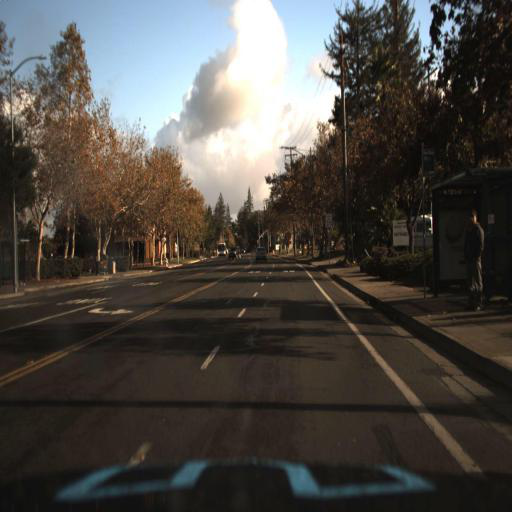

In [69]:
imae

In [71]:
imae = imae.resize((412,412))

In [72]:
width, height =imae.size

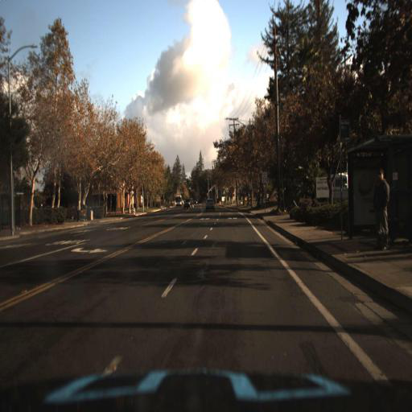

In [73]:
imae

In [74]:
scaled_boxes = []
for box in load_txt:
    
    _,xmid,ymid,w,h = box
    
    xmin = int((xmid - (w/2) ) * width)
    ymin = int((ymid - (h/2)) * height)
    xmax = int((xmid + (w/2)) * width)
    ymax = int((ymid + (h/2)) * height)
    
    scaled_boxes.append([xmin,ymin,xmax,ymax])

In [75]:
scaled_boxes

[[175, 195, 182, 207],
 [184, 198, 194, 209],
 [203, 196, 215, 212],
 [375, 165, 390, 255]]

In [76]:
from PIL import ImageDraw

In [77]:
draw = ImageDraw.Draw(imae)

for box in scaled_boxes:
    draw.rectangle(box,outline = "red")
    
# imae

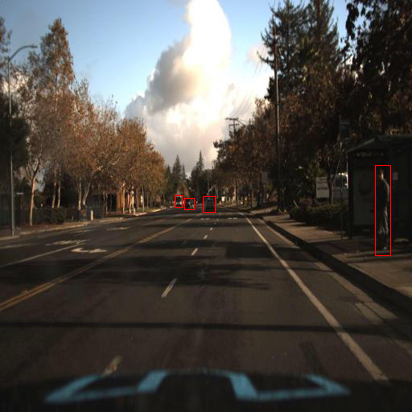

In [78]:
imae

### Make getitem 

In [81]:
from utils import iou_width_height

In [85]:
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]
IMAGE_SIZE = 416
C = 11
S = [13, 26, 52]

In [86]:
anchrs = torch.tensor(anchors[0] + anchors[1] + anchors[2])

In [87]:
anchrs

tensor([[0.2800, 0.2200],
        [0.3800, 0.4800],
        [0.9000, 0.7800],
        [0.0700, 0.1500],
        [0.1500, 0.1100],
        [0.1400, 0.2900],
        [0.0200, 0.0300],
        [0.0400, 0.0700],
        [0.0800, 0.0600]])

In [80]:
output = [torch.zeros((3, S, S, C + 5)) for S in S]

In [88]:
bbox_tensor = torch.Tensor(load_txt)

In [98]:
bbox_tensor

tensor([[10.0000,  0.4336,  0.4883,  0.0166,  0.0283],
        [ 1.0000,  0.4590,  0.4941,  0.0244,  0.0264],
        [ 1.0000,  0.5088,  0.4971,  0.0283,  0.0381],
        [ 2.0000,  0.9287,  0.5107,  0.0361,  0.2188]])

In [97]:
for bbx in bbox_tensor:
    
    class_,xmid,ymid,width, height = bbx 
    # print(bbx)
    iou_anchors = iou_width_height(bbx[2:4] , anchrs)
    sorted_anchors = iou_anchors.argsort(descending = True)
    
    has_anchor = [False] * 3
    
    for anch in sorted_anchors:
        scale_idx = anch // 3
        anch_idx = anch % 3
        
        scale = S[scale_idx]
        
        i,j = int(scale*ymid) , int(scale*xmid)
        # print(i,j)
        cell_x,cell_y = (scale*xmid) - j, (scale*ymid) - i
        
        status = output[scale_idx][anch_idx, i,j,0]
        if not status and not has_anchor[scale_idx]:
            output[scale_idx][anch_idx, i,j,0] = 1
            
            newW,newH = (scale*width),(scale*height)
            newbbox = torch.tensor([cell_x,cell_y,newW,newH])
            
            output[scale_idx][anch_idx, i,j,1:5] = newbbox
            output[scale_idx][anch_idx, i,j,5] = class_
            
            has_anchor[scale_idx] = True
            
        elif not status and iou_anchors[anch] > 0.5:
            output[scale_idx][anch_idx, i,j,0] = -1
            
        
    print(sorted_anchors)

x
x
x
tensor([8, 4, 0, 3, 7, 5, 6, 1, 2])
x
tensor([4, 8, 0, 3, 7, 5, 1, 6, 2])
x
x
x
tensor([4, 8, 0, 3, 5, 7, 1, 6, 2])
x
x
x
tensor([4, 0, 8, 3, 5, 1, 7, 6, 2])


In [103]:
anchors

[[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
 [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
 [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]]

In [100]:
S = [13, 26, 52]
scaled_anchors = torch.tensor(anchors) / (
    1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
)

In [114]:
torch.tensor(anchors)/torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)

tensor([[[0.0215, 0.0169],
         [0.0292, 0.0369],
         [0.0692, 0.0600]],

        [[0.0027, 0.0058],
         [0.0058, 0.0042],
         [0.0054, 0.0112]],

        [[0.0004, 0.0006],
         [0.0008, 0.0013],
         [0.0015, 0.0012]]])

In [101]:
scaled_anchors

tensor([[[ 3.6400,  2.8600],
         [ 4.9400,  6.2400],
         [11.7000, 10.1400]],

        [[ 1.8200,  3.9000],
         [ 3.9000,  2.8600],
         [ 3.6400,  7.5400]],

        [[ 1.0400,  1.5600],
         [ 2.0800,  3.6400],
         [ 4.1600,  3.1200]]])

In [102]:
scaled_anchors.shape

torch.Size([3, 3, 2])

In [ ]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()
